In [1]:
# create feature pickles to use around the place
# humpback whale pickle with new annots
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/tests/get_features', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import utils
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import librosa

def get_feature(samp, nfft, fs=4000):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=fs, n_mfcc=8, n_fft=nfft,hop_length=int(nfft/4)).T
    feat = useful.get_log_power_feature(samp, nfft=nfft)[2:,:]
    return feat

In [4]:
from whale.setup import get_data, constants, annotations
from whale.setup.constants_01 import *
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

# constants for fe and what not
fs = 4000 #4000 49000

labels_set = [HUMPBACK, SOUTHERN_RIGHT_WHALE, BRYDES, BOWHEAD, SPERM, NOISE] #, HUMPBACK_B, BOWHEAD, NOISE]
num_to_label = {i: labels_set[i] for i in range(len(labels_set))}
label_to_num = {labels_set[i] : i for i in range(len(labels_set))}

get_data_dict = {
    HUMPBACK: [get_data.GetDataSimple(HPB_WTK_DATA,HPB_WTK_LABEL_ALL, fs, useful.file_to_audio)],
    SOUTHERN_RIGHT_WHALE: [get_data.GetDataSimple(SRW_WTK_DATA,SRW_WTK_LABEL, fs, useful.file_to_audio)],
    BRYDES: [get_data.GetDataSimple(BRD_VRS_DATA,BRD_VRS_LABEL, fs, useful.file_to_audio)],
    BOWHEAD: [get_data.GetDataSimple(BWH_YTD_DATA,BWH_YTD_LABEL, fs, useful.file_to_audio)],
    SPERM: [get_data.GetDataSimple(SPM_WTK_DATA_0,SPM_WTK_LABEL_0, fs, useful.file_to_audio),
            get_data.GetDataSimple(SPM_WTK_DATA_1,SPM_WTK_LABEL_1, fs, useful.file_to_audio),
            get_data.GetDataSimple(SPM_WTK_DATA_2,SPM_WTK_LABEL_2, fs, useful.file_to_audio)],
    NOISE: [get_data.GetDataSimple(BRD_VRS_DATA,BRD_VRS_NOISE, fs, useful.file_to_audio),
            get_data.GetDataSimple(HPB_MBY_DATA,HPB_MBY_NOISE, fs, useful.file_to_audio)]
}

In [5]:
samples, labels = useful.get_samples(get_data_dict, labels_set, label_to_num)

__collected samples__
HPB :  76
SRW :  63
BRD :  40
BWH :  38
SPM :  33
NOISE :  46


In [6]:
from python_speech_features.base import mfcc

In [17]:
def normalize_features(feats, per_feature=False):
    if per_feature:
        normalised_feats = []
        for feat in feats:
            mean = np.mean(feat, axis=0)
            std_dev = np.std(feat, axis=0)
            normalised_feats.append((feat - mean) / std_dev)
        return normalised_feats
    else:
        all_features_concat = np.concatenate(feats)
        mean = np.mean(all_features_concat, axis=0)
        std_dev = np.std(all_features_concat, axis=0)
        return [((feat - mean) / std_dev) for feat in feats], {'mean': mean, 'std': std_dev}

def average_features(some_feature, avg_over, d):
    new_n = len(some_feature) // avg_over
    avg_features = np.empty((new_n, d))

    for i in range(new_n):
        start_idx = i * avg_over
        end_idx = (i + 1) * avg_over
        avg_features[i, :] = np.mean(some_feature[start_idx:end_idx, :], axis=0)
    return avg_features

In [10]:
# from scipy.interpolate import interp1d
#
all_features = []
nfft = 128 # 256 # 256 # 256 #128 # 256 #128
average_over = 3
to_remove = []

for i in range(len(samples)):
    sample = samples[i]
    # feat = mfcc(sample, nfft=nfft,samplerate=4000, numcep=13)
    # feat_a = librosa.feature.mfcc(y=sample,sr=4000, n_mfcc=13, n_fft=nfft).T
    feat_b = get_feature(sample, nfft)
    if average_over > 1: feat_b = average_features(feat_b, average_over, feat_b.shape[1])
    # try:
    #     interp_func = interp1d(np.linspace(0, 1, len(feat_a)), feat_a, axis=0, kind='linear')
    # except Exception as e:
    #     # Handle any other unexpected exceptions
    #     print("An unexpected error occurred:", e)
    #     to_remove.append(i)
    #     all_features.append([-1])
    #     continue
    # new_indices = np.linspace(0, 1, len(feat_b))
    # interpolated_mfcc_features = interp_func(new_indices)
    # combined_features = np.concatenate((feat_b, interpolated_mfcc_features), axis=1)
    all_features.append(feat_b) #152 129

if len(to_remove) > 0:
    print(to_remove)
    # all_features = [value for index, value in enumerate(all_features) if index not in to_remove]
    # samples = [value for index, value in enumerate(samples) if index not in to_remove]
    # labels = [value for index, value in enumerate(labels) if index not in to_remove]

In [11]:
np.min([len(feat) for feat in all_features])

3

In [9]:

# for label in labels_set:
#     print(label_to_num[label])
#     # get feature
#     locs = np.where([i==label_to_num[label] for i in labels])[0]
#     feature = all_features[locs[0]]
#     print(label)
#     # utils.plot_spectrogram(feature)
#     useful.vis_helper(feature)
#     print('\n')

In [29]:
normalized_features, mean_std = normalize_features(all_features, False)
averaged_features = [average_features(feat, 5, feat.shape[1]) for feat in all_features]

In [30]:
# # plot one of each
# for label in labels_set:
#     print(label_to_num[label])
#     # get feature
#     locs = np.where([i==label_to_num[label] for i in labels])[0]
#     feature = averaged_features[locs[0]]
#     print(label)
#     useful.vis_helper(feature)
#     print('\n')

In [18]:
import noisey

def get_noise_for_sample(signal_sample, sig_db=-16, snr_1=30, snr_2=30, snr_3=30):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)

    noisey_sample, _ = noisey.generate_gaussian_noise(len(signal_sample), noise_power_1, noise_power_2, noise_power_3)
    return noisey_sample


In [ ]:
# val = useful.SampleHolder(cv_output[VAL_DATA][0], cv_output[VAL_LABEL][0])
#
# def show_avg_powers(list_of_labels, sample_holder):
#     for lab in list_of_labels:
#         indices = sample_holder.sample_labels == lab
#         samps = [item for item, condition in zip(sample_holder.samples, indices) if condition]
#         avg_power = noisey.get_signal_avg_db(np.concatenate(samps))
#         avg_power_v2 = utils.get_average_power(np.concatenate(samps), use_buffer=True)
#         print('label: ', lab, ' | avg power: ', avg_power, ' | v2: ',  10 * np.log10(avg_power_v2))
#
# show_avg_powers(np.array([0,1,2,3]), val)

In [15]:
# feat = averaged_features
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)
from hmmlearn.hmm import GaussianHMM
n_folds = 2
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.2)
# cv_output = cv.split_data_for_cross_validation(all_features, labels, n_folds, test_ratio=0.2)

In [14]:
import pickle
# Pickle for reading in Python
output = open('cv_output_all_whales_log_power_avg_3' + ".pkl", "wb")
pickle.dump({'cv_output': cv_output, 'label_map': label_to_num, 'num_map': num_to_label}, output)
output.close()

In [37]:
n_states = 8
inits = 5
nfft = 128
snr = 20
base_snr = 50
average_over = 1
add_noise = True
should_normalise = False
should_average = True
signal_avg_db = -17 # from inspection

In [38]:
from final.models.fhmm import FactorialHMM
from final.tests import decode_combine as dc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
importlib.reload(dc)

# simple testing
preds = {}
preds_fhmm = {}

all_features = [get_feature(sample, nfft) for sample in samples]
# _, mean_std_global = normalize_features(all_features)

for i in range(n_folds):
    cv_index = i
    mean_std = None
    preds[cv_index] = []
    preds_fhmm[cv_index] = []
    true_noise_features = []
    print('cv_index: ',cv_index)
    train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
    val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
    test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_DATA])

    # train and val data
    train.features = []
    for i in range(len(train.samples)):
        feat = get_feature(train.samples[i], nfft)
        train.features.append(get_feature(train.samples[i], nfft))

    # test.features = []
    # for i in range(len(test.samples)):
    #     feat = get_feature(test.samples[i], nfft)
    #     test.features.append(get_feature(test.samples[i], nfft))

    if should_normalise: train.features, mean_std = normalize_features(train.features)
    if should_average: train.features = [average_features(feat, average_over, feat.shape[1]) for feat in train.features]

    val.features = []
    for i in range(len(val.samples)):
        # add noise maybe
        val_sample = val.samples[i]
        if add_noise:
            noise_sample = get_noise_for_sample(val.samples[i], signal_avg_db, snr, snr, base_snr)
            noise_feature = get_feature(noise_sample, nfft)
            if should_normalise and mean_std is not None: noise_feature = (noise_feature - mean_std['mean']) / mean_std['std']
            if should_average: noise_feature = average_features(noise_feature, average_over, noise_feature.shape[1])
            true_noise_features.append(noise_feature)
            val_sample = val_sample + noise_sample
        feat = get_feature(val_sample, nfft)
        # normalise / average
        if should_normalise and mean_std is not None: feat = (feat - mean_std['mean']) / mean_std['std']
        if should_average: feat = average_features(feat, average_over, feat.shape[1])

        # feat = average_features(feat, average_over, feat.shape[1])
        val.features.append(feat)

    val.update_feature_labels()
    preds[str(cv_index) + 'true'] = np.concatenate(val.feature_labels)
    preds_fhmm[str(cv_index) + 'true'] = np.concatenate(val.feature_labels)

    # go over inits
    for init in range(inits):
        print('init: ', init)
        hmms = {lab: GaussianHMM(n_states, covariance_type='diag') for lab in labels_set}
        for lab in hmms:
            print('fitting ', lab)
            cur_hmm = hmms[lab]
            feat_indicis = train.sample_labels == label_to_num[lab]
            hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
            cur_hmm.fit(np.concatenate(hmm_features))

        combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])
        _, val_pred, val_log_prob = combined_model.decode_hmmlearn(np.concatenate(val.features))

        preds[cv_index].append(val_pred)

        if add_noise:
            noise_hmm = GaussianHMM(n_states, covariance_type='diag')
            noise_hmm.fit(np.concatenate(true_noise_features))
            fhmms = {}
            for key in hmms:
                fhmm = FactorialHMM(hmms[key], noise_hmm)
                fhmms[key] = fhmm.hmm

            combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

            _, val_pred_fhmm, _ = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))
            preds_fhmm[cv_index].append(val_pred_fhmm)


cv_index:  0
init:  0
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE
init:  1
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE
init:  2
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE
init:  3
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE
init:  4
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE
cv_index:  1
init:  0
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE
init:  1
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE
init:  2
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE
init:  3
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE
init:  4
fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE


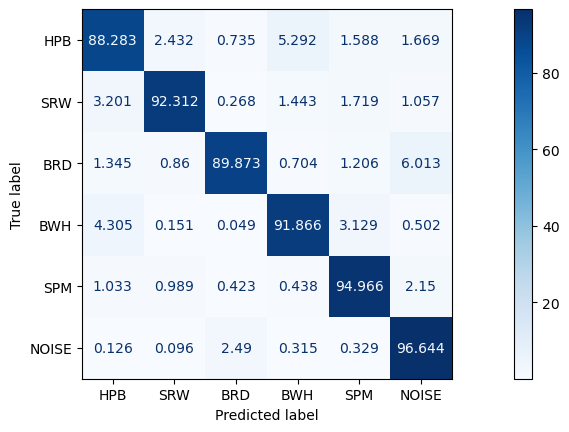

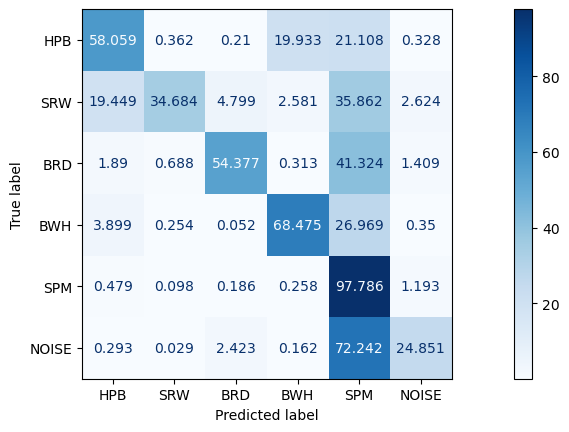

In [39]:
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()
cms = []
for i in range(n_folds):
    pred_cv = preds[i]
    true_cv = preds[str(i) + 'true']
    for pred in pred_cv:
        cm = confusion_matrix(true_cv, pred, labels=[0,1,2,3,4,5], normalize='true')
        cms.append(cm)
avg_cm = useful.get_average_cm(cms)
avg_cm = np.round(avg_cm * 100000) / 1000
disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm,display_labels=labels_set)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

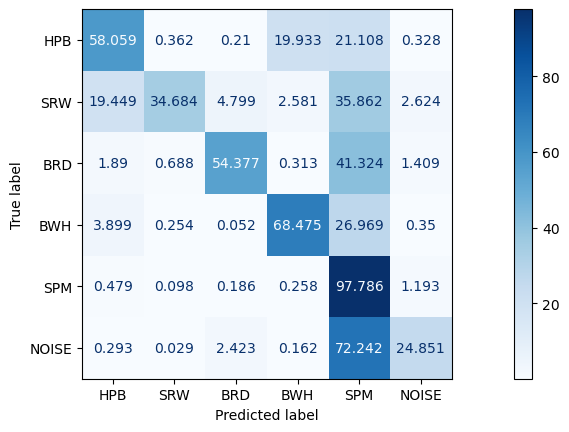

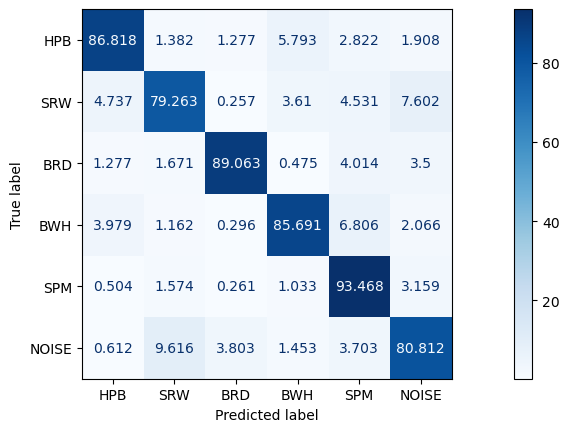

In [40]:
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()
cms = []
for i in range(n_folds):
    pred_cv = preds_fhmm[i]
    true_cv = preds_fhmm[str(i) + 'true']
    for pred in pred_cv:
        cm = confusion_matrix(true_cv, pred, labels=[0,1,2,3,4,5], normalize='true')
        cms.append(cm)
avg_cm = useful.get_average_cm(cms)
avg_cm = np.round(avg_cm * 100000) / 1000
disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm,display_labels=labels_set)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

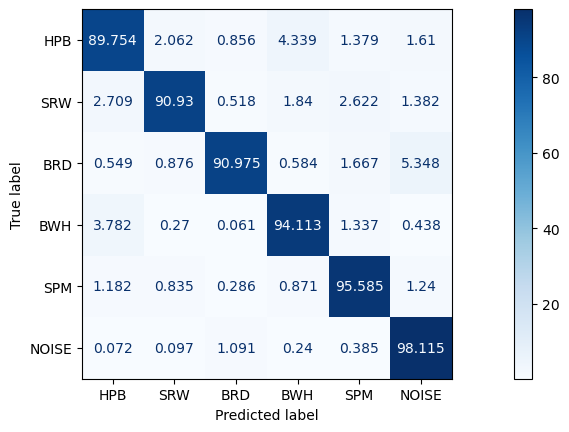

In [126]:
avg_cm = useful.get_average_cm(cms)
avg_cm = np.round(avg_cm * 100000) / 1000
disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm,display_labels=labels_set)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [134]:
# import pickle
# # Pickle for reading in Python
# output = open('cv_output_log_power_avg' + ".pkl", "wb")
# pickle.dump(cv_output, output)
# output.close()

In [135]:
# simple testing
cv_index = 0
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])

In [136]:
# train hmms


fitting  HPB
fitting  SRW
fitting  BRD
fitting  BWH
fitting  SPM
fitting  NOISE


In [140]:
np.unique(val_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 760, 1037,  103, 2311,  615,  362]))

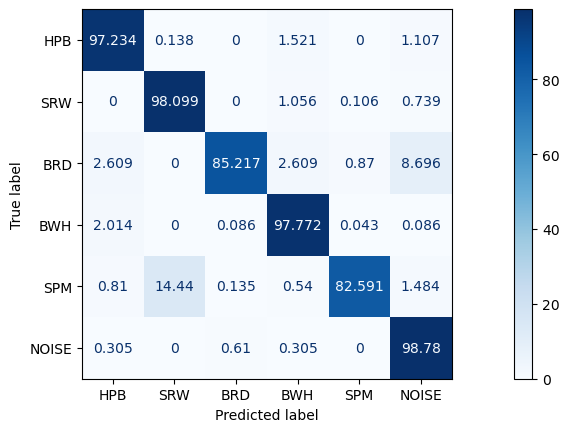

In [47]:
cv_index = 0
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])

In [48]:
# train.features = []
# for sample in train.samples:
#     train.features.append(get_feature(sample, nfft))
#
# val.features = []
# for sample in val.samples:
#     val.features.append(get_feature(sample, nfft))
#
# features_0 = {
#     train: train,
#     val: val
# }

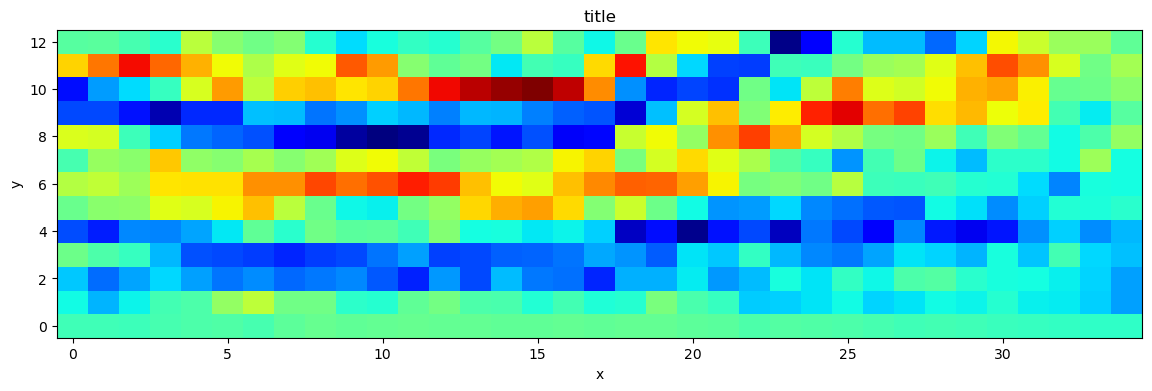

In [49]:
utils.plot_spectrogram(train.samples[4])

In [94]:
# train
features_concat = np.vstack(train.features)
features_len = [0]
n_doc = 0
rolling_total = 0

for i in range(len(train.features)):
    features_len.append(len(train.features[i]) + rolling_total)
    rolling_total += len(train.features[i])
    n_doc += 1

class MyGroupXData:
    def __init__(self, X, TrueParams, Xprev, column_names, dim, doc_range, nDoc, nDocTotal, true_state_names):
        self.X = X
        self.TrueParams = TrueParams
        self.Xprev = Xprev
        self.column_names = column_names
        self.dim = dim
        self.doc_range = doc_range
        self.nDoc = nDoc
        self.nDocTotal = nDocTotal
        self.true_state_names = true_state_names

bnpy_dataset = MyGroupXData(
    features_concat,
    {},
    features_concat, np.array([]), features_concat.shape[1],
    np.array(features_len), n_doc, n_doc, np.array([]))

bnpy_dataset.TrueParams['Z'] = np.zeros(bnpy_dataset.X.shape[0])
bnpy_dataset.TrueParams['K'] = 10

In [ ]:
import pickle
# Pickle for reading in Python
output = open('humpback_v1_bnpy_dataset' + ".pkl", "wb")
pickle.dump(bnpy_dataset, output)
output.close()


In [120]:
output = open('humpback_v1_bnpy_dataset_val' + ".pkl", "wb")
pickle.dump([train.features, val.features], output)
output.close()

In [95]:
# /Users/david/Documents/mastersCode/ubm/final/tests/get_features/humpback_v1.pkl


In [110]:
from hmmlearn.hmm import GaussianHMM

def normalize_matrix(matrix):
    matrix += 1e-40
    return matrix / np.sum(matrix, axis=(matrix.ndim - 1), keepdims=True)

def get_hmm_from_bnp(bnpy_params):
    # creat hmm
    hmm_bnpy = GaussianHMM(n_components=len(bnpy_params['pi']), covariance_type='diag', init_params='')
    hmm_bnpy.n_features = bnpy_params['means'].shape[1]
    hmm_bnpy.transmat_, hmm_bnpy.startprob_, hmm_bnpy.means_ = \
        normalize_matrix(bnpy_params['A']), normalize_matrix(bnpy_params['pi']), bnpy_params['means']
    hmm_bnpy.covars_ = bnpy_params['covars']
    return hmm_bnpy

def score_hmm(some_hmm: GaussianHMM, features_array):
    scores = []
    for i in range(len(features_array)):
        scores.append(some_hmm.score(features_array[i]) / len(features_array[i]))
    print(np.sum(scores))

In [113]:
# np.sum([len(feat) for feat in val.features])
# len(np.concatenate(val.features))
# hmm_bnpy.score(np.concatenate(val.features), [len(feat) for feat in val.features])
hmm_bnpy_params = pickle.load(open(r'humpback_v1_bnpy.pkl', 'rb'))
hmm_bnpy_inf = get_hmm_from_bnp(hmm_bnpy_params)
score_hmm(hmm_bnpy_inf, val.features)

-4121.527308537601


In [122]:
hmm_bnpy_params_fin = pickle.load(open(r'humpback_v1_bnpy_finite.pkl', 'rb'))
hmm_bnpy_fin = get_hmm_from_bnp(hmm_bnpy_params_fin)
score_hmm(hmm_bnpy_fin, val.features)

-4130.720037111644


In [116]:
hmm_bnpy_params_em = pickle.load(open(r'humpback_v1_bnpy_finite_em.pkl', 'rb'))
hmm_bnpy_em = get_hmm_from_bnp(hmm_bnpy_params_em)
score_hmm(hmm_bnpy_em, val.features)

-4011.275237299567


In [117]:
hmm_em = GaussianHMM(n_components=hmm_bnpy_em.n_components, covariance_type='diag')
hmm_em.fit(features_concat, [len(feat) for feat in train.features])
score_hmm(hmm_em, val.features)

-4045.4698365868853


-170109.73696452862